In [1]:
import numpy as np
import seaborn as sns
from obspy.clients import fdsn
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime

# For correlation
from __future__ import print_function
from scipy.signal import correlate, correlation_lags
from obspy.signal.cross_correlation import xcorr_pick_correction

import warnings
warnings.filterwarnings("ignore")

# 1) Funções



In [2]:
# 1) Get phase time pick and waveform_id.id (net, sta, loc, chan)
def evpicks(evid, phases = ['P'], station = None, client = 'http://10.110.0.135:18003'):
    '''
    str, str (default=SeisVL) list['str'] --> str, float

    Connect to SeisVL and get the event corresponded to ID given.
    After that, gets the first event preferred origin and it's arrivals and
    yield station code (net.sta.loc.chan) and the time pick of phases  list
    given.
    '''
    
    cl_e = fdsn.Client(client) if type(client) == str else client

    #Confere se o ID existe na SeisVL
    try:
        evp = cl_e.get_events(eventid = evid, includearrivals=True)
    except:
        print(f'No event with {evid} ID detected. Make sure it is in Vale event list (val2025....)!') # None
        return [(None, None)]

    #Pega o 1o evento e sua origem preferida
    E = evp[0]
    O = E.preferred_origin()

    # Faço um laço para as chegadas, pois delas eu tiro a fase que eu quero + ID
    # Com o ID de A eu comparo com o ID do Pick, se bater eu fico com o Pick (que carrega
    # informação do tempo e da waveform ID, que é o código da estação)
    all_data = []
    for A in O.arrivals:
        if A.time_weight <= 0.0: continue
        if A.phase not in phases: continue
        P = [ P for P in E.picks if P.resource_id == A.pick_id ][0]
        
        if station is not None and station == P.waveform_id.id:
            return [ (P.waveform_id.id, P.time) ] 

        all_data.append((P.waveform_id.id, P.time))

    if station is not None:
        raise Exception("Station {} not found.".format(station))

    return all_data

#-----------------------------------------------------------------------------------------------------------------------------------------------#
# 2) Get trace information and UTC and Relative time of each sample
def evtrace(sta, tp, t0, t1, fmin=2.0, fmax=10.0, margin = 2.0):
    '''
    str, float, float, float, float (opt), float (opt), float (opt) --> numpy.ndarray, numpy.ndarray

    Connect to SeisVL and get the waveform of a given period of time, returning the 
    waverform and the relative time.
    '''
    
    ## Clients
    cl_e = fdsn.Client("http://10.110.0.135:18003")
    data = cl_e.get_waveforms(*sta.split("."), starttime=t0 - margin, endtime=t1 + margin, attach_response=True)
    
    ## Errors
    ##
    if len(data) == 0:
        raise Exception("No data")
    elif len(data) > 1:
        raise Exception("Data with gap")
    
    ## Process
    ##
    trace = data[0]
    trace.detrend()
    trace.filter("bandpass", freqmin=fmin, freqmax=fmax)
    trace.trim(t0,t1)
    
    return trace

#-----------------------------------------------------------------------------------------------------------------------------------------------#
# 3) Pick correction function
def Ppick_cc(trace1, trace2, maxshift):
    """
    Trace, Trace, float --> list, list, float

    Utilizes cross-correlation between two given traces to 
    correct P phase pick.
    """
    
    dt = trace1.stats.delta
    corr = correlate(trace1.data, trace2.data, mode='valid')
    lags = correlation_lags(len(trace1.data), len(trace2.data), mode='valid')
    
    if abs(lags[corr.argmax()] * dt) <= maxshift:
        OFFSET = lags[corr.argmax()] * dt
    else:
        OFFSET = 0

    return corr, lags, OFFSET

#-----------------------------------------------------------------------------------------------------------------------------------------------#
# 4) Trim data with the same amount of samples needed
def npts_cut(tr, t0, length=2, npts=None, offset=0):
    '''
    Trace, UTCDateTime, int, int, float --> Trace
    
    tr     = trace
    t0     = UTCDateTime (para o cut)
    length = tempo em segundos de dados
    npts   = tempo em número de amostras desejado
    '''
    
    # Converte tempo relativo para UTC
    if not type(t0) == UTCDateTime:
        for i, t in enumerate(tr.times()):
            if t == t0:
                t0 = tr.times("utcdatetime")[i]
                break
    # Acha o tempo da amostra mais próxima do tempo dado = t0
    t0real = tr.times("utcdatetime")[(np.abs(tr.times("utcdatetime")-t0+offset).argmin())]-tr.stats.delta/2.0

    # Antes de cortar faz uma copia para não destruir o traco original
    trc = tr.copy()

    # Corta exatamente npts amostras
    if npts is None:
        trc.trim(t0real, t0real + length, nearest_sample=False)    
    else:
        trc.trim(t0real, t0real + npts * tr.stats.delta, nearest_sample=False)
   
    return trc

#-----------------------------------------------------------------------------------------------------------------------------------------------#
# 5) Builds post correlation correction matrix
def corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=5,fmax=15, start1=0.2,start2=4, end1=2,end2=2, maxshift=20, n_samples=None, correction=True):
    """
    Creates a corrected P pick correlation matrix.

    ev_id: list of events IDs.

    station: station code (example: VL.SLBO..HHZ).

    t0: initial time to trim data in seconds [s].

    phase: list with the phase you would like to make a graph.

    fmin: minimum frequency [Hz] to cut (high-pass).
    fmax: maximum frequency [Hz] to cut (low-pass).

    start1: beginning of first trace (must be the smaller one). 
            Time in seconds [s] before P arrival.
    start2: beginning of second trace (must be the bigger one).
            Time in seconds [s] before P arrival.

    end1: end of first trace (must be the smaller one).
          Time in seconds [s] after P arrival.
    end2: end of second trace (must be the bigger one).
          Time in seconds [s] after P arrival.

    maxshift: maximum shift allowed in seconds [s].

    n_samples: number of samples to cut traces.

    correction: condition if the finction should make a cross-correlation pick correction.
    """
    
    size = len(ev_id)
    # Recriando o gráfico de correlação pós ajuste
    Mcorr = np.ones([size, size])
    
    # Criando duas listas para arnazenar os lag e as formas de ondas pós correlação
    info_dict = {'data1':[], 'data2':[],'lags':[],'corr':[], 'offset' : [], 'title': []}
    
    # Laço que passa por todos os eventos em ev_id e faz a leitura e correção do pick de P para as réplicas que foram
    # registradas pela variável "station"
    
    for i in range(size):
        # Passa a lista ev_id e tira os dados da "station"
        for s1, t1 in evpicks(ev_id[i], phases=phase):
            if s1 == station:
                data1 = evtrace(station, t1, t1-start1, t1+end1, fmin, fmax)
                dt = data1.stats.delta
    
                # Passa a lista ev_id e tira as formas de ondas dos demais eventos que aconteceram em "station"
                for j in range(i + 1, size):
                    for s2, t2 in evpicks(ev_id[j], phases=phase):
                        if s2 == station:
                            # Aqui vai ser feito uma análise com um chute inicial
                            data2 = evtrace(station, t2, t2-start2, t2+end2, fmin, fmax)

                            if correction:
                                corr, lags, OFFSET = Ppick_cc(data1,data2, maxshift)
                                FACTOR1 = 1/np.max(data1.data)
                                FACTOR2 = 1/np.max(data2.data)
                                
                                info_dict['data1'].append(data1)
                                info_dict['data2'].append(data2)
                                info_dict['lags'].append(lags)
                                info_dict['corr'].append(corr)
                                info_dict['offset'].append(OFFSET)
                                info_dict['title'].append(f'{ev_id[i]}  -X-  {ev_id[j]}')
                                
                                data1 = npts_cut(data1, t0=0, npts=200)
                                data2 = npts_cut(data2, t0=0, npts=200, offset=OFFSET)
                            Mcorr[i,j] = np.abs(np.corrcoef(data1.data, data2.data)[0][1])
                            #     data1, data2 = same_length(data1, data2, t0, offset=OFFSET, n_samples=n_samples)
                            # Mcorr[i,j] = np.abs(np.corrcoef(data1.data, data2.data)[0][1])
    
    for i in range(size):
        for j in range(size):
            if j>i:
                Mcorr[j][i] = -1
    
    return Mcorr
    
###########################################################---PLOTS---###########################################################

# Plot a heatmap using a given matrix
def plot_matrix(corr_M, ev_id, figsize=(8,6), cmap="Accent_r"):
    """
    matrix, list, tuple, string --> heatmap
    
    Plot a heatmap using a given matrix
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    ### Inicial
    Max = np.max(np.abs(corr_M))
    Min = -Max
    
    sns.heatmap(
        corr_M,
        cmap=cmap,
        vmin=Min,
        vmax=Max,
        annot=True,
        ax=ax,
        xticklabels=ev_id,
        yticklabels=ev_id,
        cbar_kws={'label': 'Correlation value'}
        )
    
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_title(f'Correlation matrix\nStation code: {station} | Nº of events: {size}', fontsize=16)
    ax.tick_params(axis="x", rotation=20, labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

##################
## Print da matriz
def print_matrix(matrix, ev_id):
    """
    matrix, list --> string
    
    Print the matrix values in string format
    """
    
    size = len(ev_id)

    print('Matriz de correlação:')
    for i in range(size):
        print('|', end='   ')
        for j in range(size):
            if matrix[i,j] < 0:
                print(f'{matrix[i,j]:.2f}', end='   ')
            else:
                print(f'{matrix[i,j]:.2f}', end='    ')
        print('|', end ='')        
        print()
    print()

##################
## Plot graphs
def plot_graph(info_dict, ncols=5, figsize=(30,10)):
    """
    dict, int, tuple --> graph
    
    Plota os gráficos das formas de ondas sobrepostas pós correlação
    """
    # O número de gráficos deve ser igual ao número de correções que foram feitas
    total_de_graficos = len(info_dict['corr'])
    
    # Gostaria que tivesse, no máximo, 5 colunas. Se tiiver menos de 5 gráficos, uma coluna
    # para cada gráfico
    if total_de_graficos < 5:
        ncols = total_de_graficos
    
    # Ajustando o número de linhas de acordo com o npumero de colunas escolhidas (no caso 5)
    if total_de_graficos % ncols ==0:
        nrows = total_de_graficos//ncols
        deno = ncols
    else:
        nrows = total_de_graficos//ncols + 1
        deno = ncols + 1
    
    # Criando os gráficos
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    
    # Criando um contador que passará pelo indice do info_dict
    cont = 0
    for row in range(nrows):
        for col in range(ncols):
            title = info_dict['title'][cont]
            image = ax[row][col]
            # Plot da correlações
            #ax[row][col].plot(info_dict['lags'][cont], info_dict['corr'][cont], color='red')
            
            # Plotando o 1o evento
            Y1 = info_dict['data1'][cont]
            X1 = Y1.times()
            Y1 = Y1.data / np.max(Y1.data)
            
            image.plot(X1, Y1, color='darkorange', label=f'{title[:11]}')
            
            # Plotando o 2o evento
            Y2 = info_dict['data2'][cont]
            X2 = Y2.times() + info_dict['offset'][cont]
            Y2 = Y2.data / np.max(Y2.data)
    
            image.plot(X2, Y2, 'b--', label=f'{title[18:]}')
    
            # Configurando o gráfico
            image.set_title(title, fontsize=14)
            image.set_xlim(0.0,2.5)
            image.grid(alpha=0.25)
            image.legend(fontsize=12)
            cont += 1
            
            if cont == total_de_graficos:
                break
    
    
    plt.tight_layout()

# 2) Correlação das formas de onda


Plota a matriz de correlação das formas de onda dos eventos listados em "ev_id". Neste caso, não houve correção dos picks da onda P, então o início do evento corresponde puramente ao escolhido pelo sismologo durante a pickagem

In [3]:
# Lista de eventos
ev_id = ['val2025gmqf','val2025gmvl','val2025gmvf','val2025gmqn','val2025gmsc','val2025gnbo']
# Número de estações/dimensão da matriz nxn
size = len(ev_id)
# Estação que será extraída a forma de onda
station = 'VL.SLBO..HHZ'

In [4]:
corr_M = corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=2,fmax=10, start1=0.5,start2=0.5, end1=2,end2=2, maxshift=0, n_samples=None, correction=False)

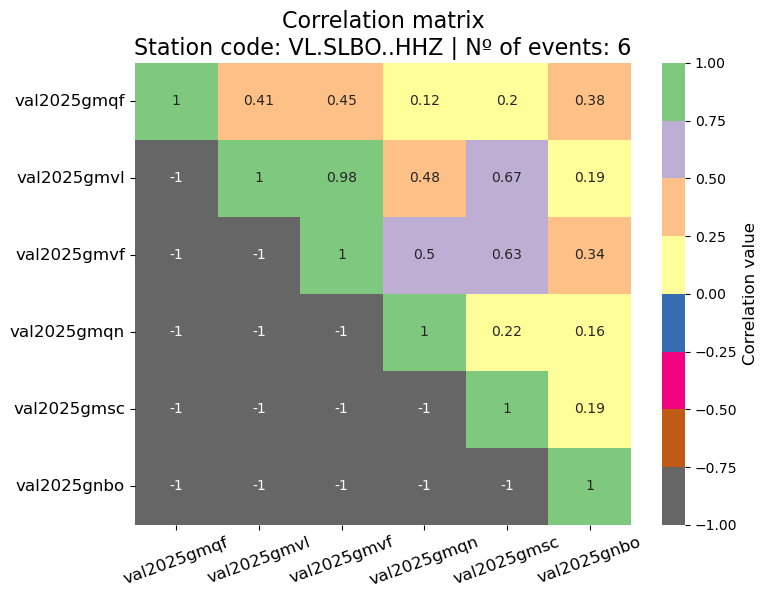

In [5]:
plot_matrix(corr_M, ev_id)
# print_matrix(corr_M, ev_id)

# 3) Correção do pick da fase P

## P pick time correction

IDEIA:

O objetivo é corrigir o tempo de coleta P movendo a coleta para o atraso (que será convertido em tempo relativo multiplicando por dt).

Só precisamos ter cuidado com os problemas de tempo relativo, então, vamos encurtar um traço de dados. Dessa forma, a correlação é válida porque um pode se mover pelo outro sem que nenhum de seus números seja isolado. Sabendo que um é mais curto, é melhor somar ou subtrair a diferença de tempo relativa entre o início dos traços.

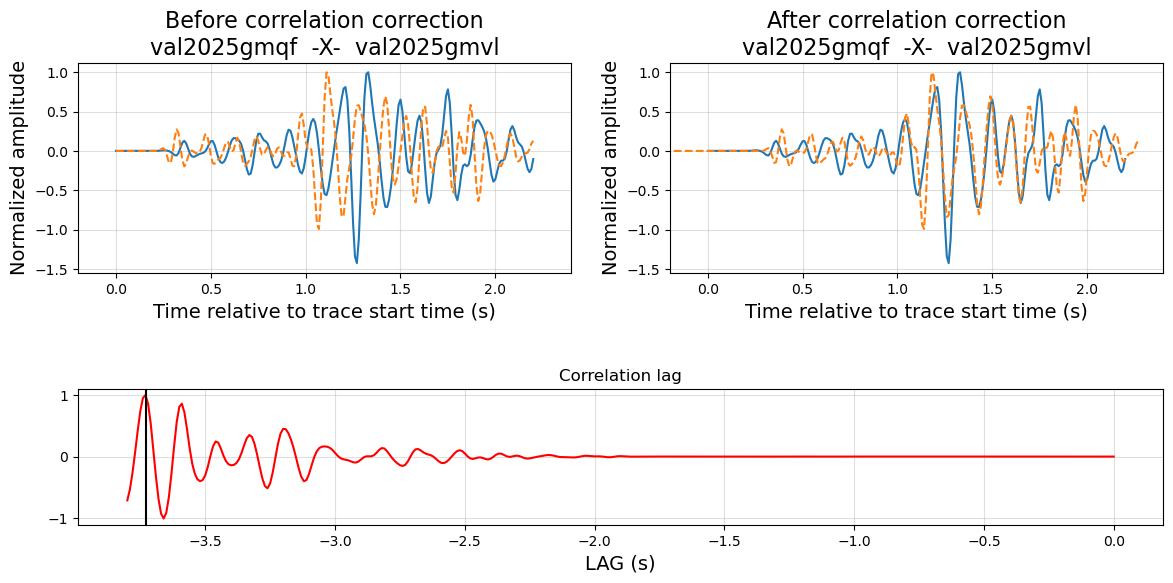

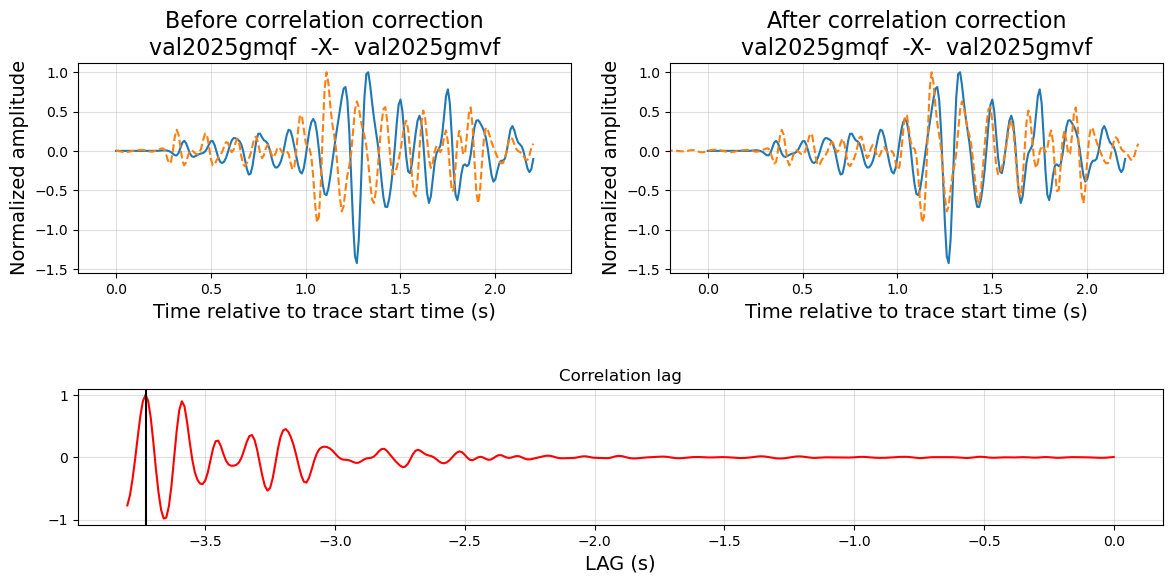

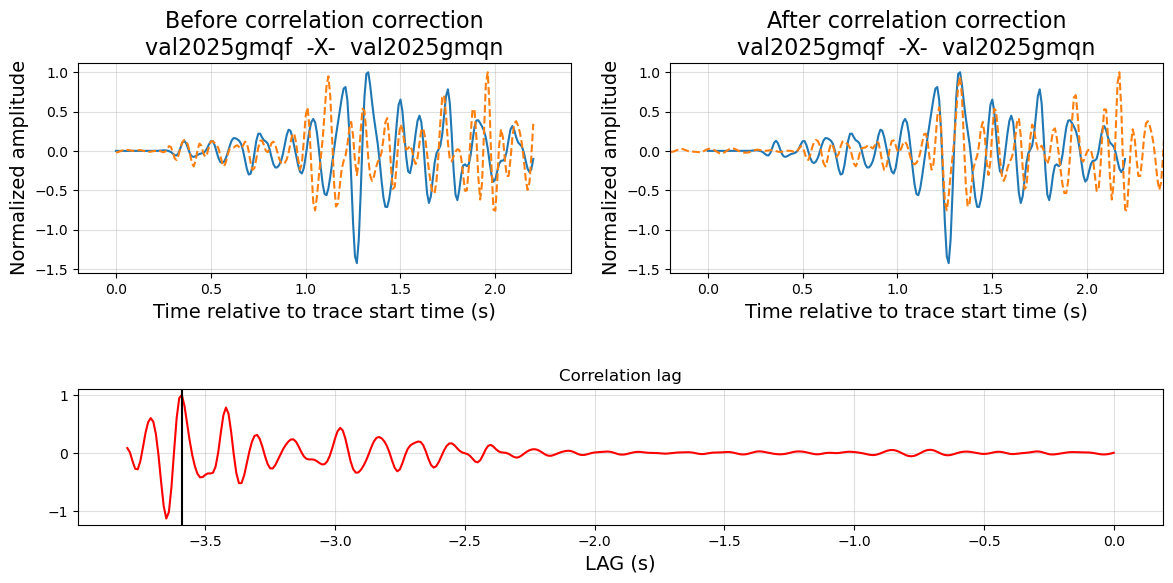

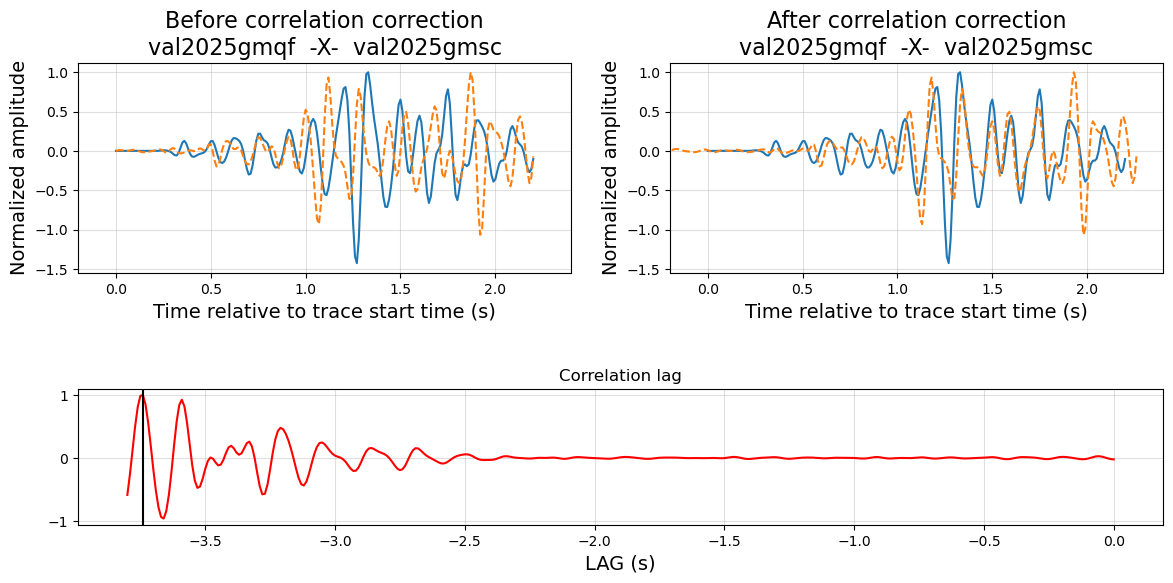

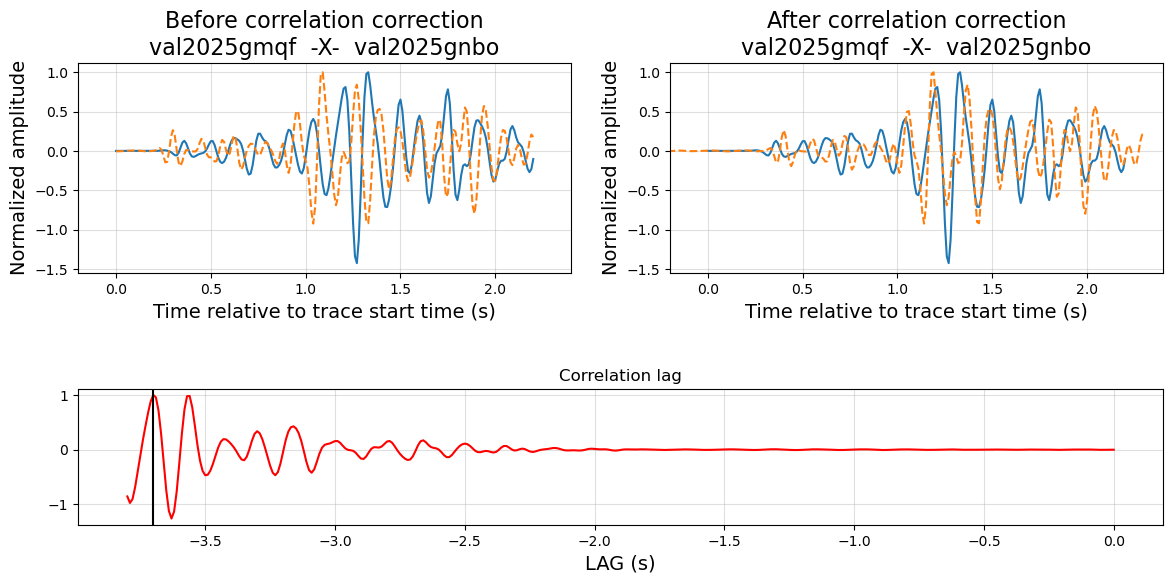

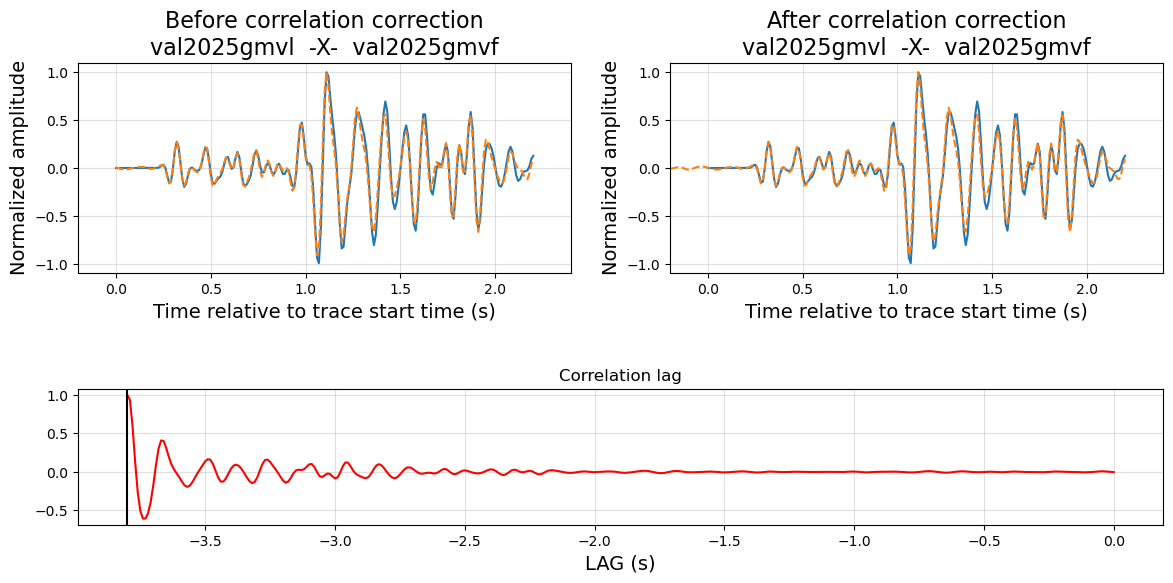

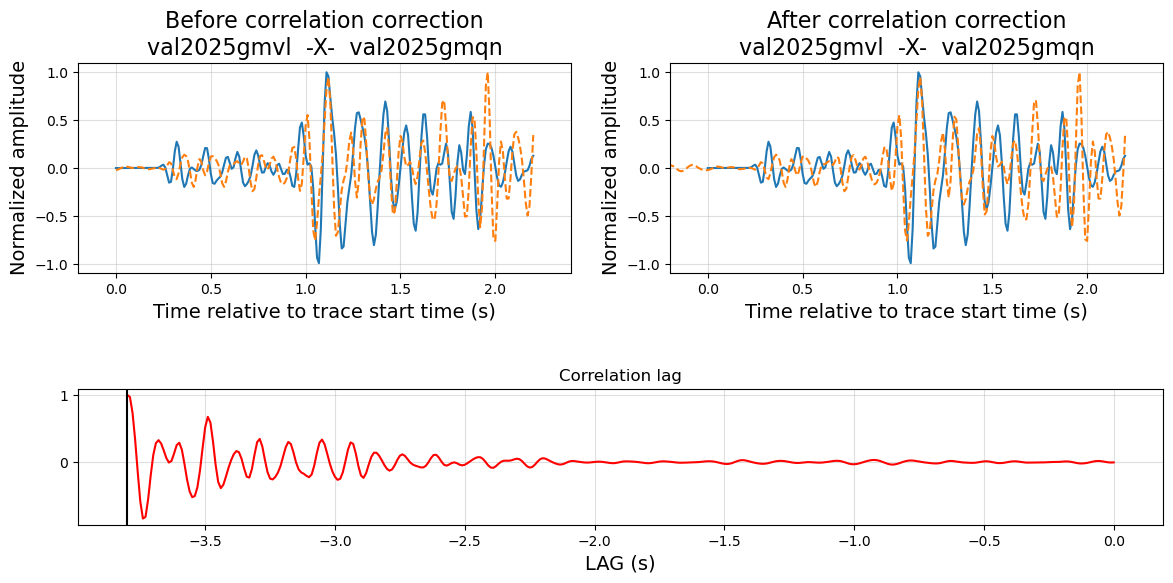

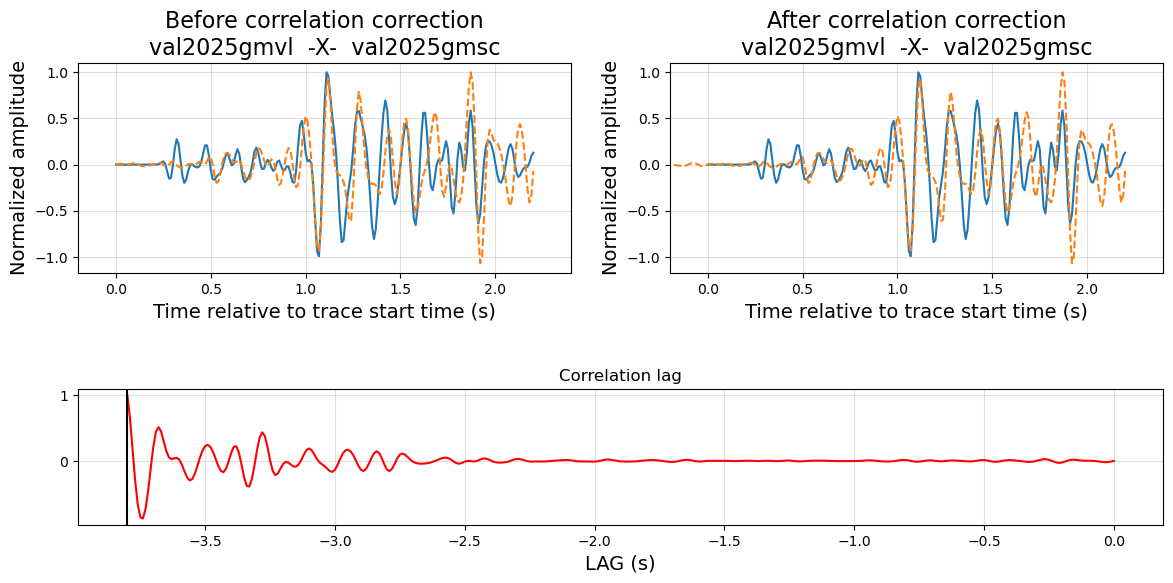

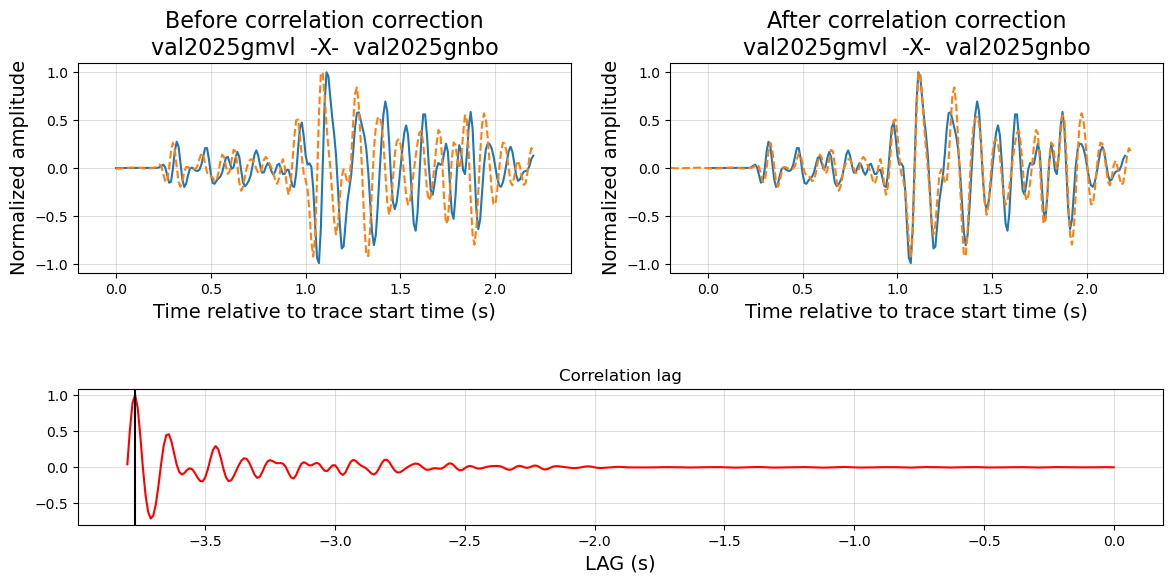

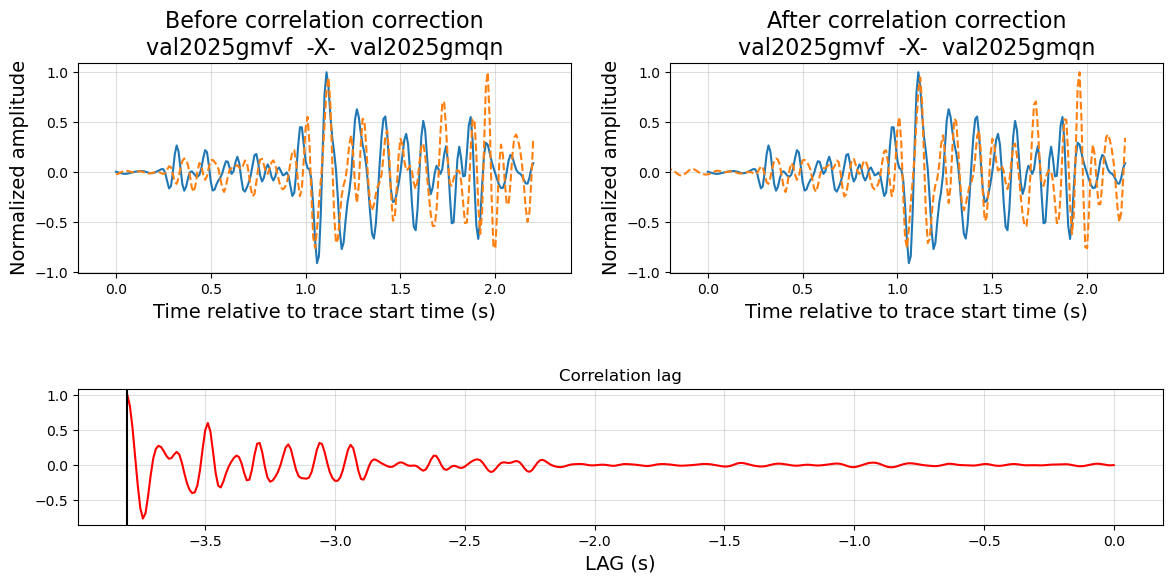

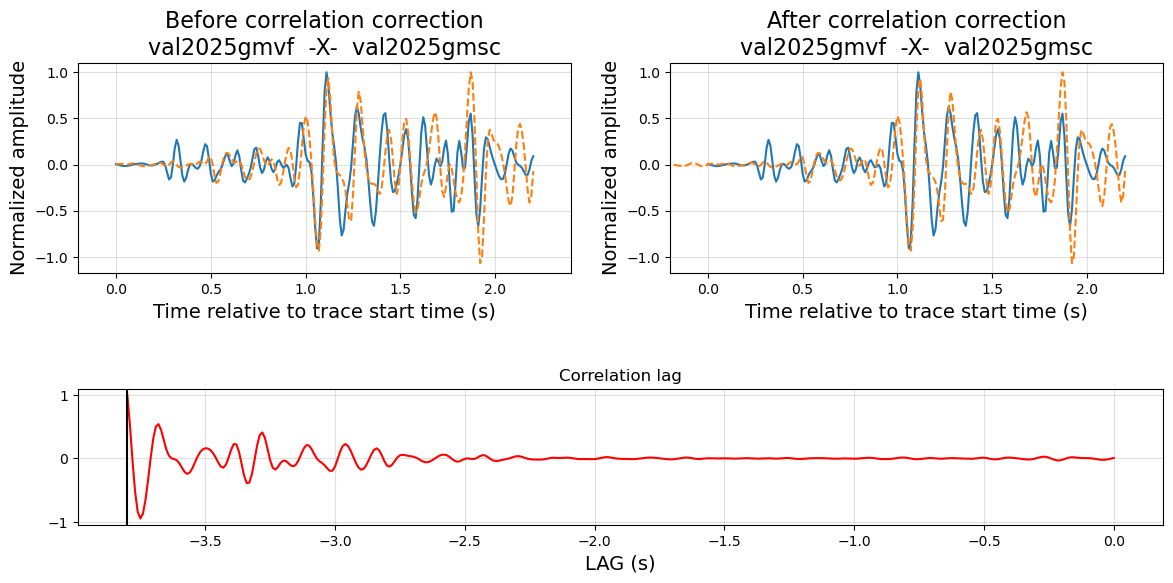

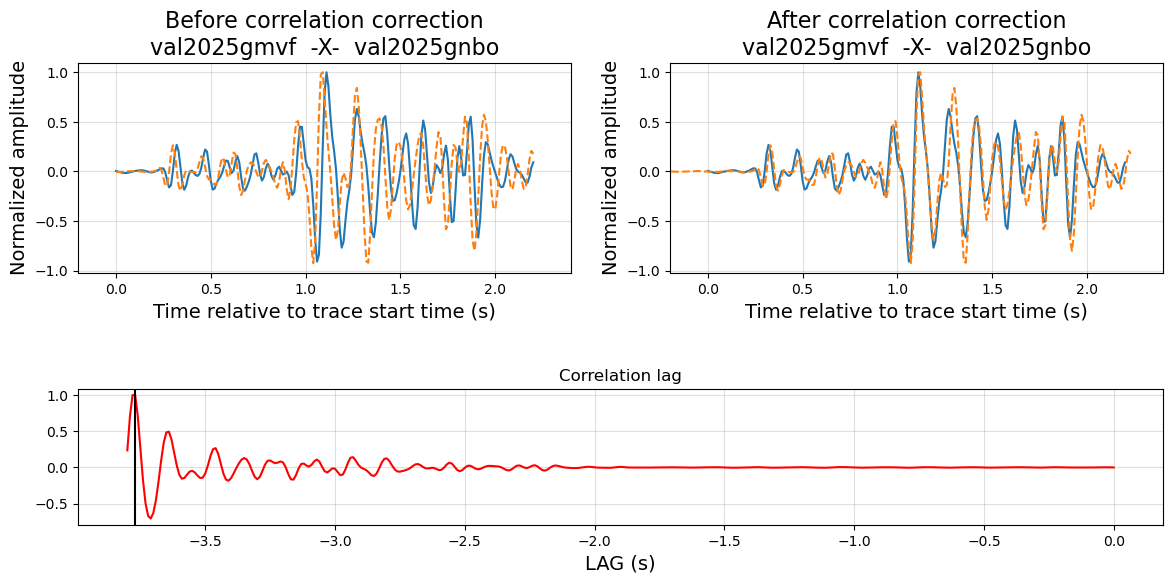

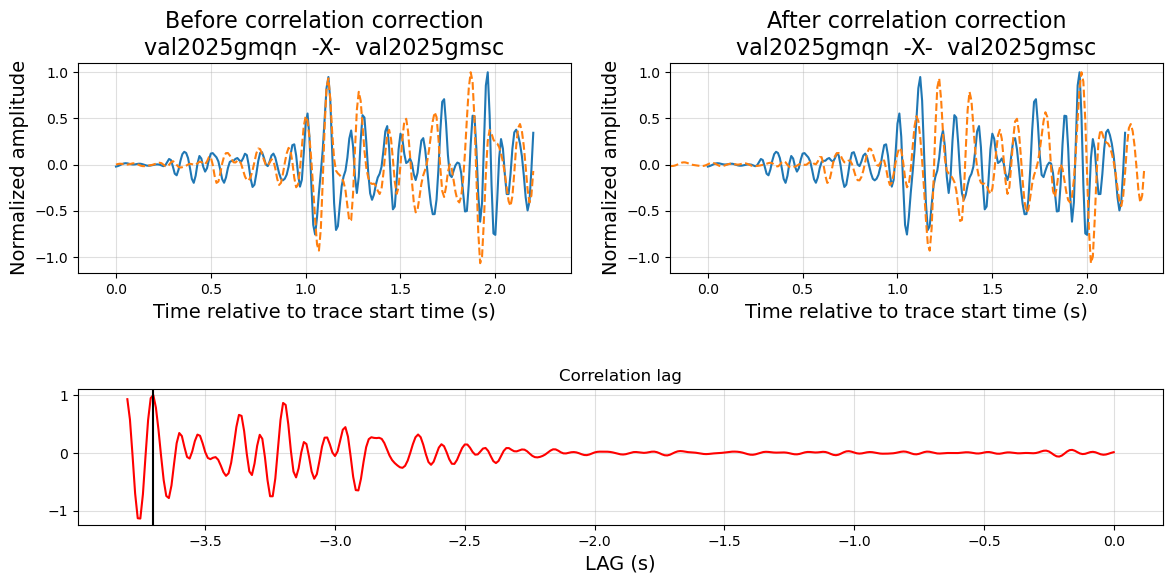

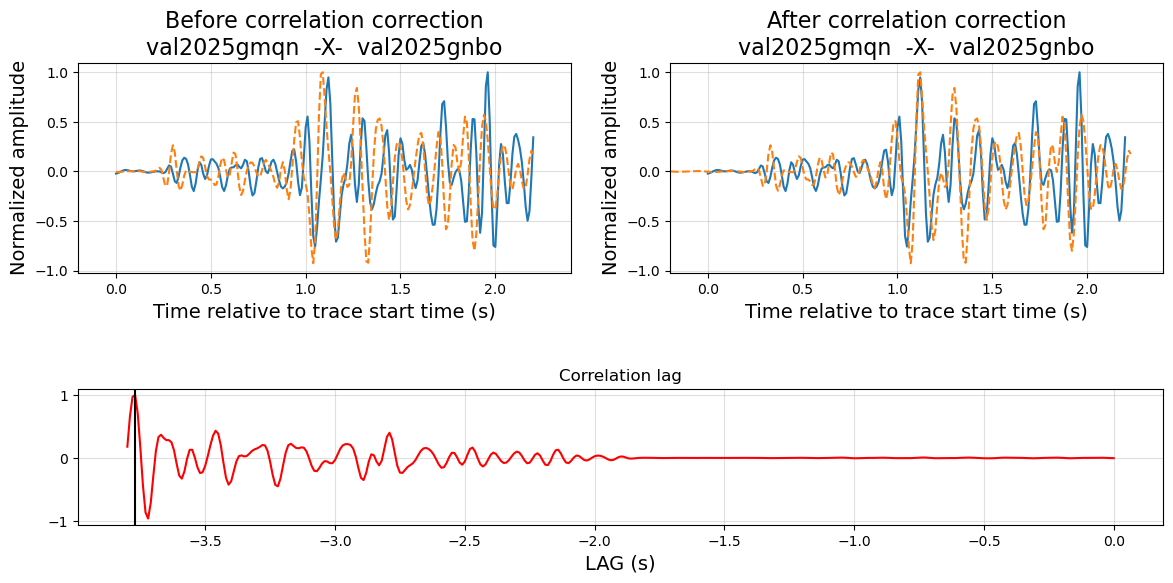

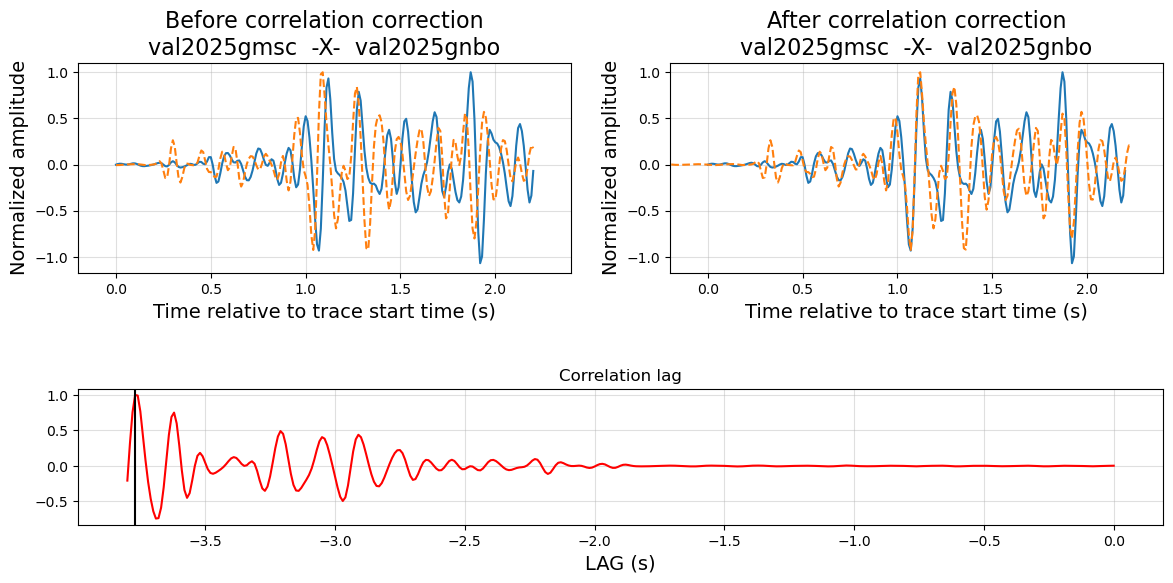

In [6]:
# Fazendo a correção do pick da onda P

# Criando duas listas para arnazenar os lag e as formas de ondas pós correlação
info_dict = {'data1':[], 'data2':[],'lags':[],'corr':[], 'offset' : [], 'title': []}

# Definindo os parâmetros para evpicks e evtrace
# 1) Filtro aplicado
fmin = 5.0
fmax = 15.0

# 2) tamanho do 1o e do 2o traço, em tempo relativo ao pick da onda P
start1 = 0.2
start2 = 4
diff_start = abs(start2 - start1)

end1 = 2
end2 = 2

maxshift= 20 # [s]

# Laço que passa por todos os eventos em ev_id e faz a leitura e correção do pick de P para as réplicas que foram
# registradas pela variável "station"

for i in range(len(ev_id)):
    # Passa a lista ev_id e tira os dados da "station"
    for s1, t1 in evpicks(ev_id[i], phases=['P']):
        if s1 == station:
            data1 = evtrace(station, t1, t1-start1, t1+end1, fmin, fmax)
            test1 = evtrace(station, t1, t1-0.2, t1+2, fmin, fmax)
            dt = data1.stats.delta

            # Passa a lista ev_id e tira as formas de ondas dos demais eventos que aconteceram em "station"
            for j in range(i + 1, len(ev_id)):
                for s2, t2 in evpicks(ev_id[j], phases=['P']):
                    if s2 == station:
                        # Aqui vai ser feito uma análise com um chute inicial
                        data2 = evtrace(station, t2, t2-start2, t2+end2, fmin, fmax)
                        test2 = evtrace(station, t2, t2-0.2, t2+2, fmin, fmax)
                        corr , lags, OFFSET = Ppick_cc(data1, data2, maxshift)
                        FACTOR1 = 1/np.max(data1.data)
                        FACTOR2 = 1/np.max(data2.data)
                        
                        info_dict['data1'].append(data1)
                        info_dict['data2'].append(data2)
                        info_dict['lags'].append(lags)
                        info_dict['corr'].append(corr)
                        info_dict['offset'].append(OFFSET)
                        info_dict['title'].append(f'{ev_id[i]}  -X-  {ev_id[j]}')
                        
                        # Plot
                        plt.figure(figsize=(14,6))
                        ax1 = plt.subplot(2,2,1)
                        ax1.set_title(f"Before correlation correction\n{ev_id[i]}  -X-  {ev_id[j]}", fontsize=16) 
                        ax1.plot(test1.times(), test1.data * FACTOR1)
                        ax1.plot(test2.times(), test2.data * FACTOR2, "--")
                        ax1.set_xlim((-0.2,2.4))
                        ax1.set_xlabel(f"Time relative to trace start time (s)\n\n", fontsize=14)
                        ax1.set_ylabel("Normalized amplitude", fontsize=14)
                        ax1.grid(alpha=0.4)
                        
                        ax2 = plt.subplot(2,2,2, sharey=ax1)
                        ax2.set_title(f"After correlation correction\n{ev_id[i]}  -X-  {ev_id[j]}", fontsize=16) 
                        ax2.plot(data1.times(), data1.data * FACTOR1)
                        ax2.plot(data2.times() + OFFSET, data2.data * FACTOR2, "--")
                        ax2.set_xlim((-0.2,2.4))
                        ax2.set_xlabel(f"Time relative to trace start time (s)\n\n", fontsize=14)
                        ax2.set_ylabel("Normalized amplitude", fontsize=14)
                        ax2.grid(alpha=0.4)
                        
                        plt.subplot(3,1,3)
                        plt.plot( lags * dt, corr/np.max(corr), color='red')
                        plt.axvline(OFFSET, color ='k')
                        plt.grid(alpha=0.4)
                        plt.title("Correlation lag")
                        plt.xlabel('LAG (s)', fontsize=14)
                        plt.show()



# 4) Gráfico das formas de ondas sobrepostas após a correção de pick

Plotar a matriz de correlação, mas no lugar do mapa de cores, colocar os gráficos com as formas de ondas dos eventos que estão sendo comparados.

## Gráficos

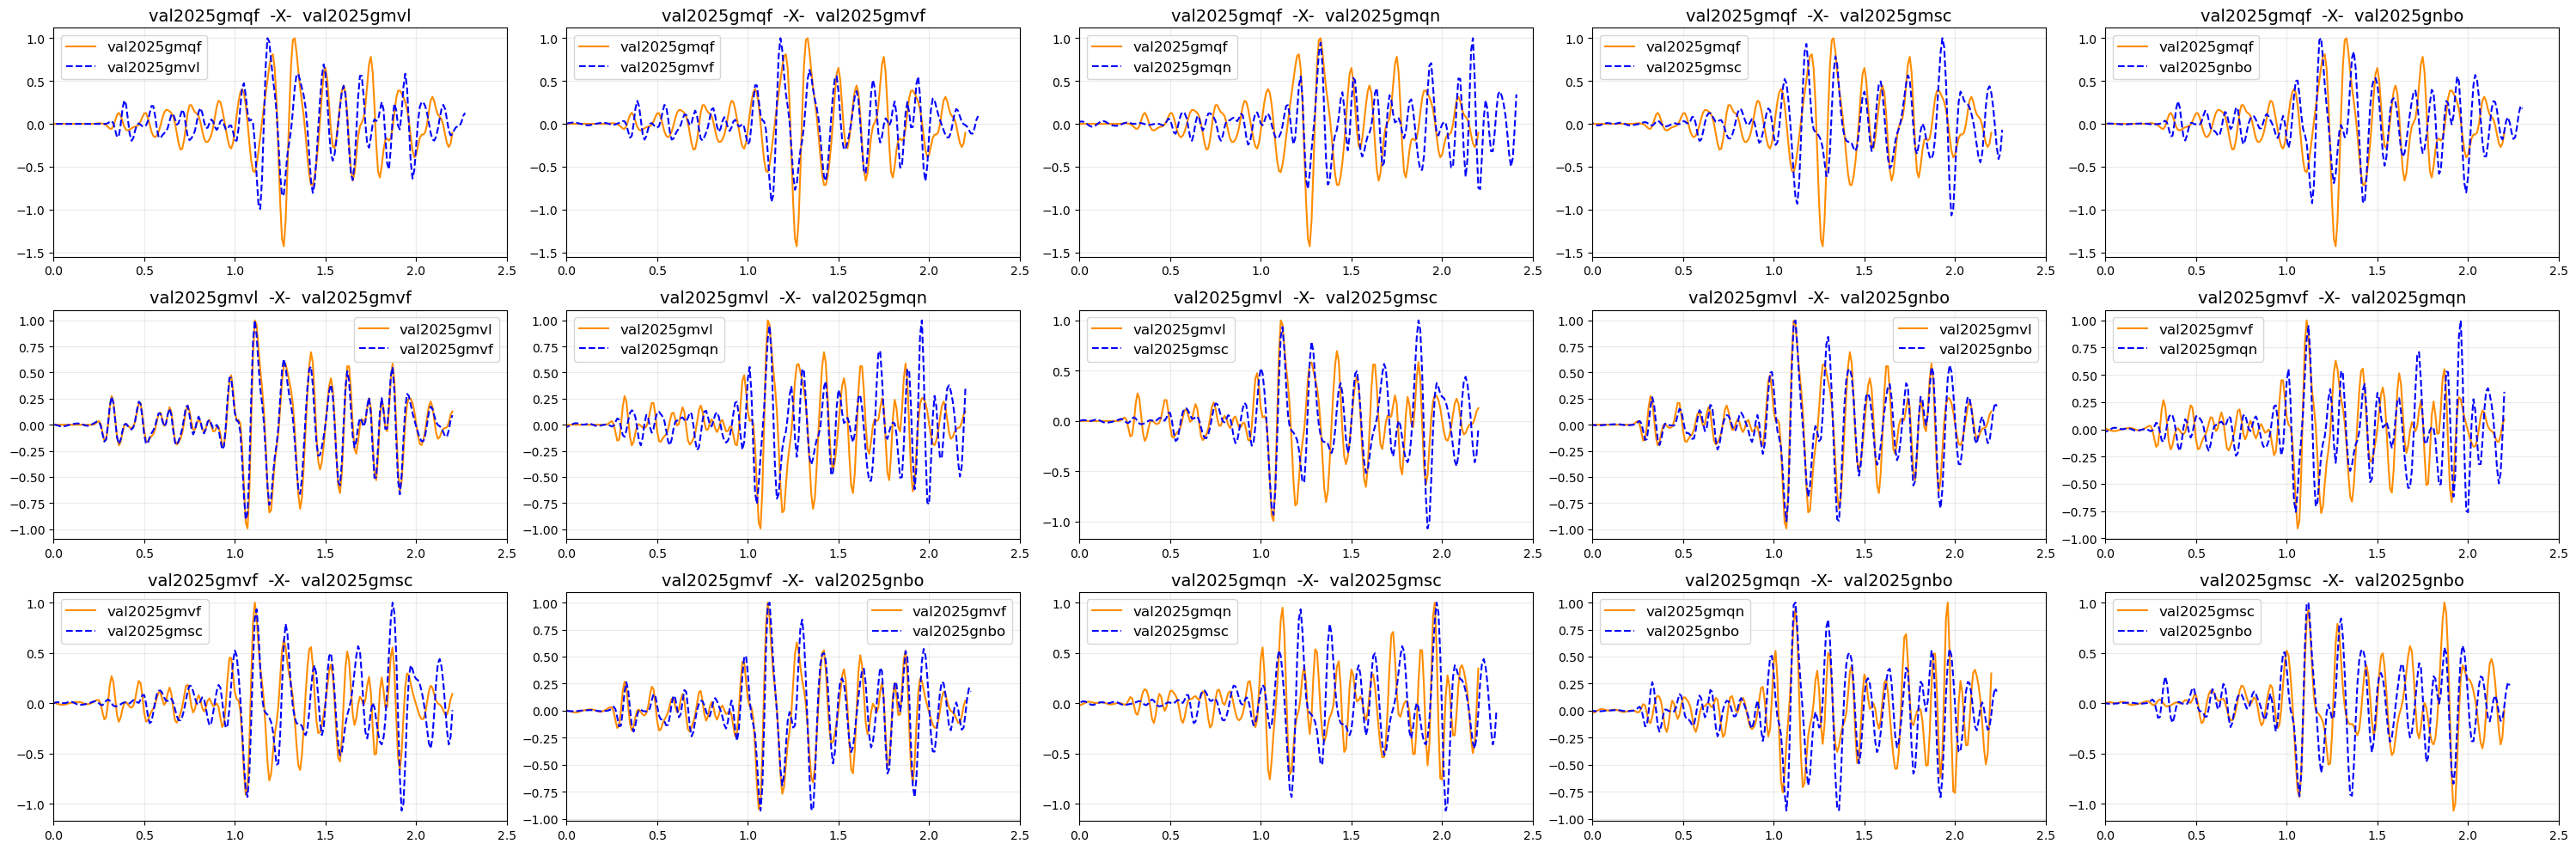

In [7]:
plot_graph(info_dict, 5, [30,10])

## Recriando a matriz de correlação

In [8]:
Mcorr=corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=5,fmax=15, start1=0.2,start2=4, end1=2,end2=2, maxshift=20, n_samples=None)

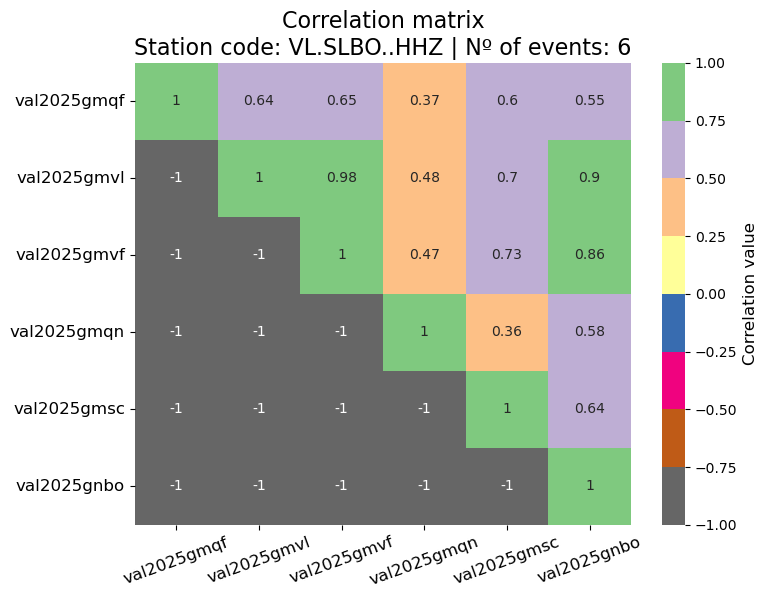

In [9]:
plot_matrix(Mcorr, ev_id)
# print_matrix(Mcorr, ev_id)

# 5) Comparando a matriz de correlação inicial com a corrigida

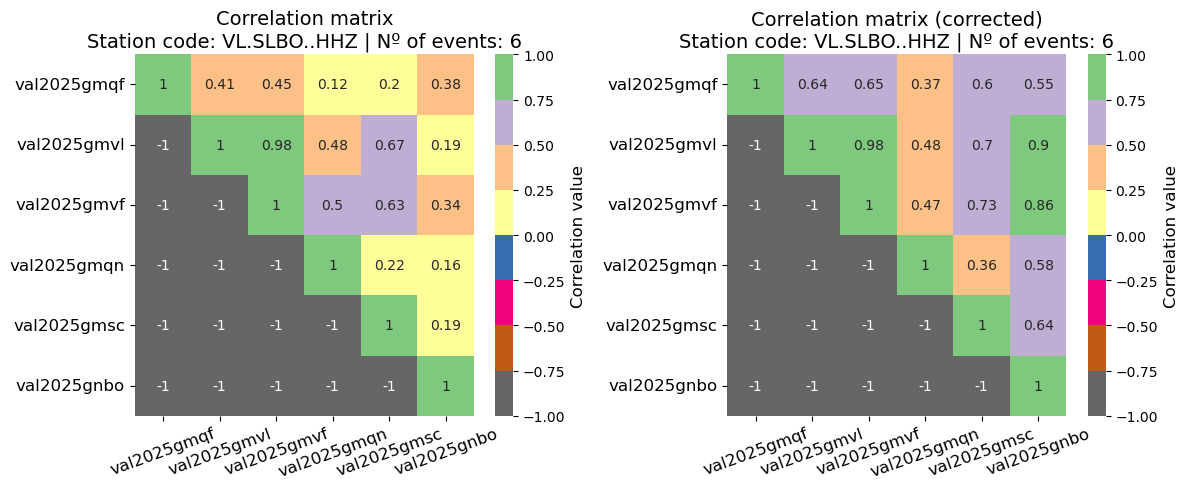

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))#(nrows=2, ncols=1, figsize=(8, 12))

### Inicial
Max = np.max(np.abs(corr_M))
Min = -Max

sns.heatmap(
    corr_M,
    cmap="Accent_r",
    vmin=Min,
    vmax=Max,
    annot=True,
    ax=ax[0],
    xticklabels=ev_id,
    yticklabels=ev_id,
    cbar_kws={'label': 'Correlation value'}
    )

ax[0].figure.axes[-1].yaxis.label.set_size(12)
ax[0].set_title(f'Correlation matrix\nStation code: {station} | Nº of events: {size}', fontsize=14)
ax[0].tick_params(axis="x", rotation=20, labelsize=12)
ax[0].tick_params(axis="y", labelsize=12)


### Corrigida
Max = np.max(np.abs(Mcorr))
Min = -Max

sns.heatmap(
    Mcorr,
    cmap="Accent_r",
    vmin=Min,
    vmax=Max,
    annot=True,
    ax=ax[1],
    xticklabels=ev_id,
    yticklabels=ev_id,
    cbar_kws={'label': 'Correlation value'}
    )

ax[1].figure.axes[-1].yaxis.label.set_size(12)
ax[1].set_title(f'Correlation matrix (corrected)\nStation code: {station} | Nº of events: {size}', fontsize=14)
ax[1].tick_params(axis="x", rotation=20, labelsize=12)
ax[1].tick_params(axis="y", labelsize=12)

plt.tight_layout()
plt.show()


## O que falta?

1) Plotar os títulos escrito "evento ID x evento ID"
2) Conferir com o Bianchi essa correção por correlação (nem todos estão no lag 0, como deveria ser após a correção)
3) Arrumar as cores do gráfico acima. Isso deve considerar o valor da correlação normalizada pelo lag 0 (igual a matriz inicial)
4) Organizar o código (tá uma zona)
5) Melhorar a documentação

## Ideias:
- Plotar um sismograma de umas 6 horas, com linhas de 30 min do evento e das réplicas

  -> Se eu conseguir, gostaria de colocar a forma de onda dos eventos em laranja. A ideia é utilizar a forma de onda com os tempos utc que eu pego no for e usar esses tempos para localizar o evento, e plotar a forma de onda de outra cor por cima do original (em azul ou vermelho)